In [286]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### State

In [287]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]               # 사용자 입력     
    plan: Annotated[List[str], "Current plan"]          # 현재 계획
    past_steps: Annotated[List[Tuple], operator.add]    # 이전에 실행한 계획과 실행 결과
    response: Annotated[str, "Final response"]          # 답변

### 계획 모델

In [288]:
from pydantic import BaseModel, Field
from typing import List

class Plan(BaseModel):                                  # Plan 모델 정의
    """Sorted steps to execute the plan"""

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]

### 사용자 답변 모델

In [289]:
from pydantic import BaseModel

class Response(BaseModel):
    """Response to user."""

    # 사용자 응답
    response: str

### Re-Plan 모델

In [290]:
from typing import Union
from pydantic import BaseModel, Field

class Act(BaseModel):
    """Action to perform."""

    # 수행할 작업: "Response", "Plan". 사용자에게 응답할 경우 Response 사용, 추가 도구 사용이 필요할 경우 Plan 사용
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [291]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langgraph.prebuilt import create_react_agent

### 도구 정의 (웹 검색)

In [292]:
from langchain_teddynote.tools import TavilySearch

tools = [TavilySearch(max_results=1)]

### 계획 단계

In [293]:
# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
Answer in Korean.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

planner = planner_prompt | llm.with_structured_output(Plan)

### re-plan 단계

In [294]:
# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Answer in Korean."""
)


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

# Replanner 생성
replanner = replanner_prompt | llm.with_structured_output(Act)

### Agent (작업 실행 에이전트)

In [295]:
# 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

# ReAct 에이전트 생성
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

In [296]:
# Planner 실행
planner.invoke({"messages": [("user","겔럭시폰을 만든 회사는?")]})

Plan(steps=["'겔럭시폰'이라는 제품명을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", "삼성전자가 '겔럭시폰'을 만든 회사임을 결론짓는다."])

In [297]:
agent_executor.invoke(
    {"messages": [("user", "겔럭시폰을 만든 회사는?")]}
)

{'messages': [HumanMessage(content='겔럭시폰을 만든 회사는?', additional_kwargs={}, response_metadata={}, id='959bc9fa-0ed5-4901-991a-c63ca06dc6fc'),
  AIMessage(content='갤럭시폰을 만든 회사는 삼성전자입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 146, 'total_tokens': 161, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-abb8afd5-a857-4582-804d-42511aa21f1c-0', usage_metadata={'input_tokens': 146, 'output_tokens': 15, 'total_tokens': 161, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

### 계획 노드

In [298]:
# 사용자 입력을 기반으로 계획을 생성하고 리턴
def plan_step(state: PlanExecute):
    print('===== plan_step() 시작 =====')
    print(f"사용자 입력: {state['input']}")

    plan = planner.invoke({"messages": [("user", state["input"])]})
    
    print('플래너 체인 실행: ')
    print(plan.steps)

    print('===== plan_step() 끝 =====')

    # 생성된 계획의 단계 리스트 리턴
    return {"plan": plan.steps}             

### Agent 노드

In [299]:
# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    print('===== execute_step() 함수 시작 =====')

    plan = state["plan"]

    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = ''

    for i, step in enumerate(plan):
        plan_str = plan_str + f"{i+1}. {step}" + '\n'

    plan_str.rstrip('\n')
    
    print(f'plan 문자열')
    print(plan_str)

    task = plan[0]

    print('실행할 task: ')
    print(task)

    # 현재 실행할 작업을 포맷팅하여 에이전트에 전달
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    
    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})
    
    print('\nagent_executor 실행: ')
    print([(task, agent_response["messages"][-1].content)])
    
    print('===== execute_step() 함수 끝 =====')


    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

### Re-Plan (재계획) 노드

In [300]:
# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    print('===== replan_step() 함수 시작 =====')

    output = replanner.invoke(state)

    print(f'replanner.invoke() 실행: ')
    print(output)

    if isinstance(output.action, Response):                 # 응답이 사용자에게 리턴한 경우
        print('[리턴] Response: ')
        print( output.action.response)
        print('===== replan_step() 함수 끝 =====')

        return {"response": output.action.response}
    else:
        next_plan = output.action.steps
        
        if len(next_plan) == 0:
            print('실행할 단계가 없는 경우: No more steps needed')            
            print('===== replan_step() 함수 끝 =====')

            return {"response": "No more steps needed."}
        else:
            print('실행할 단계가 남은 경우: ')
            print(next_plan)
            print('===== replan_step() 함수 끝 =====')

            return {"plan": next_plan}

### Agent 실행을 계속할지 결정하는 함수

In [315]:
def should_end(state: PlanExecute):
    print('===== should_end() 함수 실행 =====')

    if "response" in state and state["response"]:
        print('결과: final_report')
        return "final_report"
    else:
        print('결과: execute')
        return "execute"

In [318]:
final_report_prompt = ChatPromptTemplate.from_template(
    """You are given the objective and the previously done steps. Your task is to generate a final report in markdown format.
Final report should be written in professional tone.

Your objective was this:

{input}

Your previously done steps(question and answer pairs):

{past_steps}

Generate a final report in markdown format. Write your response in Korean."""
)


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)

output_parer = StrOutputParser()

final_report = final_report_prompt | llm | output_parer 

In [322]:
def generate_final_report(state: PlanExecute):
    print('===== generate_final_report() 함수 실행 =====')

    past_steps  = ''

    for past_step in state["past_steps"]:
        question = past_step[0]                 # 첫 번째 요소는 질문
        answer = past_step[1]                   # 두 번째 요소는 답변
        
        # 현재 질문과 답변을 포맷팅하여 `past_steps`에 추가
        formatted_step = f"Question: {question}\n\nAnswer: {answer}\n\n####"

        past_steps = past_steps + formatted_step + "\n\n"  # 각 단계 사이에 두 줄 띄우기


    print('past_steps:')
    print(past_steps)

    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})

    print('final_report 실행: ')
    print(response)
    print('===== generate_final_report() 함수 끝 =====')


    return {"response": response}

In [301]:
state1 = PlanExecute(
    input='겔럭시폰을 만든 회사는?',
    plan=["'겔럭시폰'이라는 이름을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", "삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다."] ,
    past_steps=[("겔럭시폰'이라는 이름을 확인한다.", "겔럭시폰은 스마트폰 입니다.","'겔럭시폰'이 삼성전자의 제품임을 확인한다.", "겔럭시폰은 삼성전자가 만든 스마트폰입니다.", "삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.", "삼성전자 입니다.")],
    response='겔럭시폰을 만든 회사는 삼성전자입니다. 더 이상의 추가 단계는 필요하지 않습니다.'
)

state1

{'input': '겔럭시폰을 만든 회사는?',
 'plan': ["'겔럭시폰'이라는 이름을 확인한다.",
  "'겔럭시폰'이 삼성전자의 제품임을 확인한다.",
  '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.'],
 'past_steps': [("겔럭시폰'이라는 이름을 확인한다.",
   '겔럭시폰은 스마트폰 입니다.',
   "'겔럭시폰'이 삼성전자의 제품임을 확인한다.",
   '겔럭시폰은 삼성전자가 만든 스마트폰입니다.',
   '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.',
   '삼성전자 입니다.')],
 'response': '겔럭시폰을 만든 회사는 삼성전자입니다. 더 이상의 추가 단계는 필요하지 않습니다.'}

In [302]:
plan_step(state1)           # 계획 생성

===== plan_step() 시작 =====
사용자 입력: 겔럭시폰을 만든 회사는?
플래너 체인 실행: 
["'겔럭시폰'이라는 이름의 제품을 만든 회사의 이름을 찾는다.", "'겔럭시폰'은 삼성전자가 만든 제품임을 확인한다.", '따라서, 겔럭시폰을 만든 회사는 삼성전자이다.']
===== plan_step() 끝 =====


{'plan': ["'겔럭시폰'이라는 이름의 제품을 만든 회사의 이름을 찾는다.",
  "'겔럭시폰'은 삼성전자가 만든 제품임을 확인한다.",
  '따라서, 겔럭시폰을 만든 회사는 삼성전자이다.']}

In [303]:
execute_step_result = execute_step(state1)          # aegent 실행

===== execute_step() 함수 시작 =====
plan 문자열
1. '겔럭시폰'이라는 이름을 확인한다.
2. '겔럭시폰'이 삼성전자의 제품임을 확인한다.
3. 삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.

실행할 task: 
'겔럭시폰'이라는 이름을 확인한다.

agent_executor 실행: 
[("'겔럭시폰'이라는 이름을 확인한다.", "'겔럭시폰'이라는 이름은 삼성전자의 스마트폰 브랜드인 '갤럭시'를 지칭하는 것으로 확인되었습니다. 삼성전자는 다양한 갤럭시 시리즈 스마트폰을 제조하고 있습니다.")]
===== execute_step() 함수 끝 =====


In [304]:
execute_step_result     # execute_step(): agent 실행 결과  

{'past_steps': [("'겔럭시폰'이라는 이름을 확인한다.",
   "'겔럭시폰'이라는 이름은 삼성전자의 스마트폰 브랜드인 '갤럭시'를 지칭하는 것으로 확인되었습니다. 삼성전자는 다양한 갤럭시 시리즈 스마트폰을 제조하고 있습니다.")]}

In [305]:
# re-plan 노드
replan_step(state1)

===== replan_step() 함수 시작 =====
replanner.invoke() 실행: 
action=Response(response='이미 모든 단계가 완료되었습니다. 겔럭시폰을 만든 회사는 삼성전자입니다.')
[리턴] Response: 
이미 모든 단계가 완료되었습니다. 겔럭시폰을 만든 회사는 삼성전자입니다.
===== replan_step() 함수 끝 =====


{'response': '이미 모든 단계가 완료되었습니다. 겔럭시폰을 만든 회사는 삼성전자입니다.'}

In [316]:
should_end(state1)

===== should_end() 함수 실행 =====
결과: final_report


'final_report'

In [312]:
state2 = PlanExecute(
    input='겔럭시폰을 만든 회사는?',
    plan=["'겔럭시폰'이라는 이름을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", "삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다."] ,
    past_steps=[("겔럭시폰'이라는 이름을 확인한다.", "겔럭시폰은 스마트폰 입니다.")],
    response=''
)

state2

{'input': '겔럭시폰을 만든 회사는?',
 'plan': ["'겔럭시폰'이라는 이름을 확인한다.",
  "'겔럭시폰'이 삼성전자의 제품임을 확인한다.",
  '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.'],
 'past_steps': [("겔럭시폰'이라는 이름을 확인한다.", '겔럭시폰은 스마트폰 입니다.')],
 'response': ''}

In [313]:
replan_step(state2)

===== replan_step() 함수 시작 =====
replanner.invoke() 실행: 
action=Plan(steps=["'겔럭시폰'이 삼성전자의 제품임을 확인한다.", '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.'])
실행할 단계가 남은 경우: 
["'겔럭시폰'이 삼성전자의 제품임을 확인한다.", '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.']
===== replan_step() 함수 끝 =====


{'plan': ["'겔럭시폰'이 삼성전자의 제품임을 확인한다.", '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.']}

In [317]:
should_end(state2)

===== should_end() 함수 실행 =====
결과: execute


'execute'

In [324]:
generate_final_report(state1)

===== generate_final_report() 함수 실행 =====
past_steps:
Question: 겔럭시폰'이라는 이름을 확인한다.

Answer: 겔럭시폰은 스마트폰 입니다.

####


final_report 실행: 
# 최종 보고서

## 개요

본 보고서는 "겔럭시폰을 만든 회사는?"이라는 질문에 대한 답을 찾기 위해 수행된 조사 과정을 문서화한 것입니다. 겔럭시폰은 전 세계적으로 널리 사용되는 스마트폰 브랜드로, 이 보고서는 해당 브랜드의 제조사를 확인하는 것을 목표로 합니다.

## 조사 과정

### 1. 겔럭시폰'이라는 이름을 확인한다.

- **질문:** 겔럭시폰'이라는 이름을 확인한다.
- **답변:** 겔럭시폰은 스마트폰입니다.

## 결론

조사 결과, 겔럭시폰은 삼성전자(Samsung Electronics)에서 제조한 스마트폰 브랜드입니다. 삼성전자는 한국에 본사를 두고 있는 글로벌 전자 기업으로, 겔럭시 시리즈는 그들의 대표적인 스마트폰 라인업입니다. 

이 보고서는 겔럭시폰의 제조사를 확인하는 데 중점을 두었으며, 삼성전자가 그 제조사임을 명확히 밝혔습니다. 추가적인 정보가 필요할 경우, 삼성전자의 공식 웹사이트나 관련 자료를 참조하시기 바랍니다. 

## 참고 문헌

- 삼성전자 공식 웹사이트
- 관련 기술 문서 및 보도 자료

이 보고서는 겔럭시폰의 제조사에 대한 명확한 이해를 제공하며, 관련된 추가 조사가 필요할 경우 유용한 출발점이 될 것입니다.
===== generate_final_report() 함수 끝 =====


In [325]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)
workflow.add_node("execute", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_node("final_report", generate_final_report)

# 엣지 정의
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "execute")
workflow.add_edge("execute", "replan")
workflow.add_edge("final_report", END)

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

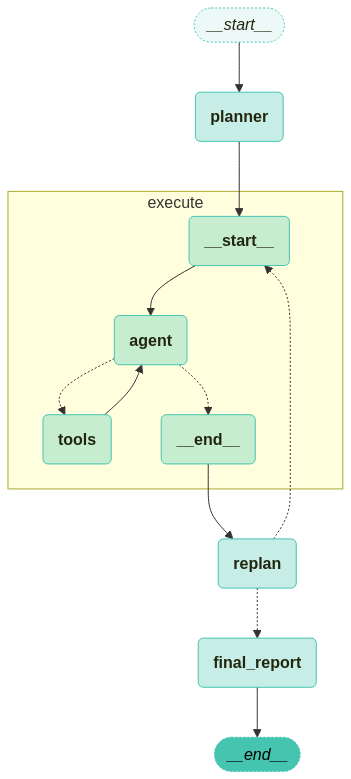

In [326]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

In [327]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": "겔럭시폰을 만든 회사는?"
}

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)

===== plan_step() 시작 =====
사용자 입력: 겔럭시폰을 만든 회사는?
플래너 체인 실행: 
["'겔럭시폰'이라는 이름을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.']
===== plan_step() 끝 =====
[node_name]: planner
[node_chunk]:
 {'plan': ["'겔럭시폰'이라는 이름을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.']}
===== execute_step() 함수 시작 =====
plan 문자열
1. '겔럭시폰'이라는 이름을 확인한다.
2. '겔럭시폰'이 삼성전자의 제품임을 확인한다.
3. 삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.

실행할 task: 
'겔럭시폰'이라는 이름을 확인한다.

agent_executor 실행: 
[("'겔럭시폰'이라는 이름을 확인한다.", "'겔럭시폰'은 삼성전자의 스마트폰 브랜드인 '갤럭시'를 의미하는 것으로 보입니다. 삼성전자는 다양한 갤럭시 스마트폰 모델을 제공하고 있습니다.")]
===== execute_step() 함수 끝 =====
[node_name]: execute
[node_chunk]:
 {'past_steps': [("'겔럭시폰'이라는 이름을 확인한다.", "'겔럭시폰'은 삼성전자의 스마트폰 브랜드인 '갤럭시'를 의미하는 것으로 보입니다. 삼성전자는 다양한 갤럭시 스마트폰 모델을 제공하고 있습니다.")]}
===== replan_step() 함수 시작 =====
replanner.invoke() 실행: 
action=Response(response="현재까지의 진행 상황에 따르면, '겔럭시폰'이 삼성전자의 제품임을 확인하였습니다. 따라서 추가적인 단계는 필요하지 않으며, 최종 결론을 내릴 수 있습니다.\n\n삼성전자가 겔럭시폰을 만든 회사입니다.")
[리턴] Response: 
현재까지의 진행 상황에 

In [329]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": "겔럭시폰을 만든 회사는?"
}

invoke_graph(app, inputs, config)

===== plan_step() 시작 =====
사용자 입력: 겔럭시폰을 만든 회사는?
플래너 체인 실행: 
["'겔럭시폰'이라는 제품명을 확인한다.", "'겔럭시폰'이 삼성전자의 제품임을 확인한다.", '삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.']
===== plan_step() 끝 =====

🔄 Node: planner 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
'겔럭시폰'이라는 제품명을 확인한다.
'겔럭시폰'이 삼성전자의 제품임을 확인한다.
삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.
===== execute_step() 함수 시작 =====
plan 문자열
1. '겔럭시폰'이라는 제품명을 확인한다.
2. '겔럭시폰'이 삼성전자의 제품임을 확인한다.
3. 삼성전자가 겔럭시폰을 만든 회사임을 결론짓는다.

실행할 task: 
'겔럭시폰'이라는 제품명을 확인한다.

🔄 Node: agent in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_3IAMPjVmFakvwLgv2JagWwHB)
 Call ID: call_3IAMPjVmFakvwLgv2JagWwHB
  Args:
    query: 겔럭시폰 제품명

🔄 Node: tools in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "갤럭시 핸드폰 기종 모델명 확인하는법 - 힙나비", "url": "

In [330]:
snapshot = app.get_state(config).values
print(snapshot["response"])

# 최종 보고서

## 목표

본 보고서의 목표는 "겔럭시폰을 만든 회사는?"이라는 질문에 대한 답변을 제공하는 것입니다.

## 조사 과정

### 질문 1: '겔럭시폰'이라는 제품명을 확인한다.

- **답변**: '겔럭시폰'은 삼성전자에서 제조하는 인기 있는 스마트폰 브랜드인 '갤럭시'를 의미합니다. 따라서 '겔럭시폰'이라는 제품명은 삼성전자의 '갤럭시' 핸드폰을 가리키는 것으로 확인되었습니다.

## 결론

조사 결과, '겔럭시폰'은 삼성전자에서 제조하는 '갤럭시' 브랜드의 스마트폰을 의미합니다. 따라서 '겔럭시폰'을 만든 회사는 삼성전자입니다.

## 참고 문헌

- 삼성전자 공식 웹사이트
- 관련 기술 문서 및 제품 설명서

본 보고서는 위의 조사 과정을 통해 얻은 정보를 바탕으로 작성되었습니다. 추가적인 질문이나 정보가 필요하신 경우, 관련 자료를 참조하시기 바랍니다.


In [331]:
from IPython.display import Markdown

Markdown(snapshot["response"])

# 최종 보고서

## 목표

본 보고서의 목표는 "겔럭시폰을 만든 회사는?"이라는 질문에 대한 답변을 제공하는 것입니다.

## 조사 과정

### 질문 1: '겔럭시폰'이라는 제품명을 확인한다.

- **답변**: '겔럭시폰'은 삼성전자에서 제조하는 인기 있는 스마트폰 브랜드인 '갤럭시'를 의미합니다. 따라서 '겔럭시폰'이라는 제품명은 삼성전자의 '갤럭시' 핸드폰을 가리키는 것으로 확인되었습니다.

## 결론

조사 결과, '겔럭시폰'은 삼성전자에서 제조하는 '갤럭시' 브랜드의 스마트폰을 의미합니다. 따라서 '겔럭시폰'을 만든 회사는 삼성전자입니다.

## 참고 문헌

- 삼성전자 공식 웹사이트
- 관련 기술 문서 및 제품 설명서

본 보고서는 위의 조사 과정을 통해 얻은 정보를 바탕으로 작성되었습니다. 추가적인 질문이나 정보가 필요하신 경우, 관련 자료를 참조하시기 바랍니다.